In [5]:
import emcee 
import numpy as np
import pylab as mplot
%pylab inline
from scipy.optimize import minimize


%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [6]:
TauRho = np.load('Tau_Rho.npz')

rho0p=TauRho['rho0p']
rho0p_err=TauRho['rho0p_err']
rho0m=TauRho['rho0m']
rho0m_err=TauRho['rho0m_err']

rho1p=TauRho['rho1p']
rho1p_err=TauRho['rho1p_err']
rho1m=TauRho['rho1m']
rho1m_err=TauRho['rho1m_err']

rho2p=TauRho['rho2p']
rho2p_err=TauRho['rho2p_err']
rho2m=TauRho['rho2m']
rho2m_err=TauRho['rho2m_err']

rho3p=TauRho['rho3p']
rho3p_err=TauRho['rho3p_err']
rho3m=TauRho['rho3m']
rho3m_err=TauRho['rho3m_err']

rho4p=TauRho['rho4p']
rho4p_err=TauRho['rho4p_err']
rho4m=TauRho['rho4m']
rho4m_err=TauRho['rho4m_err']

rho5p=TauRho['rho5p']
rho5p_err=TauRho['rho5p_err']
rho5m=TauRho['rho5m']
rho5m_err=TauRho['rho5m_err']

tau0p=TauRho['tau0p']
tau0p_err=TauRho['tau0p_err']
tau0m=TauRho['tau0m']
tau0m_err=TauRho['tau0m_err']

tau2p=TauRho['tau2p']
tau2p_err=TauRho['tau2p_err']
tau2m=TauRho['tau2m']
tau2m_err=TauRho['tau2m_err']

tau5p=TauRho['tau5p']
tau5p_err=TauRho['tau5p_err']
tau5m=TauRho['tau5m']
tau5m_err=TauRho['tau5m_err']

theta=TauRho['theta']

In [7]:
def log_probability(theta, x, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr)

def log_prior(theta):
    m, b, log_f = theta
    if -5.0 < m < 0.5 and 0.0 < b < 10.0 and -10.0 < log_f < 1.0:
        return 0.0
    return -np.inf

def log_likelihood1(p1, x1, y1, yerr1):
    A, B, C = p1
    model = A*rho0p + B*rho2p + C*rho5p
    sigma2 = yerr1**2
    return -0.5 * np.sum((y1 - model) ** 2 / sigma2)

def log_likelihood2(p2, x2, y2, yerr2):
    A, B, C = p2
    model = A*rho2p + B*rho1p + C*rho4p
    sigma2 = yerr2**2
    return -0.5 * np.sum((y2 - model) ** 2 / sigma2)

def log_likelihood3(p3, x3, y3, yerr3):
    A, B, C = p3
    model = A*rho5p + B*rho4p + C*rho3p
    sigma2 = yerr3**2
    return -0.5 * np.sum((y3 - model) ** 2 / sigma2)


def log_likelihood(p, x1, x2, x3, y1, y2, y3, yerr1, yerr2, yerr3):
    return log_likelihood1(p, x1, y1, yerr1) + log_likelihood2(p, x2, y2, yerr2) + log_likelihood3(p, x3, y3, yerr3)  

0.010504330116851198 -0.019830758316657322 2.71698354362577


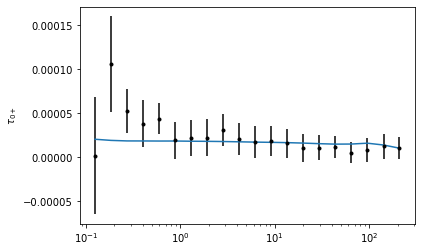

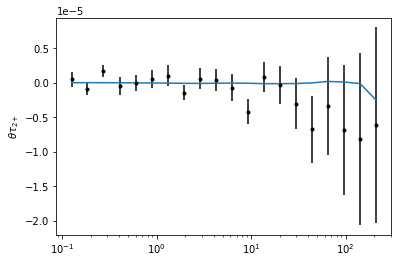

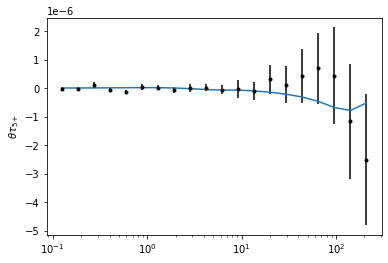

In [8]:
nll = lambda *args: -log_likelihood(*args)
initial = np.array([0.0, 1.0, 1.0])
soln = minimize(nll, initial, args=(theta, theta, theta, tau0p, tau2p, tau5p, tau0p_err, tau2p_err, tau5p_err))
alpha_ml, beta_ml, eta_ml = soln.x
print(alpha_ml, beta_ml, eta_ml)

mplot.figure()
mplot.errorbar(theta, tau0p, tau0p_err, fmt=".k", capsize=0)
mplot.xscale('log')
mplot.ylabel('$\\tau_{0+}$')
mplot.plot(theta, alpha_ml*rho0p+beta_ml*rho2p+eta_ml*rho5p)

mplot.figure()
mplot.errorbar(theta, theta*tau2p, theta*tau2p_err, fmt=".k", capsize=0)
mplot.xscale('log')
mplot.ylabel('$\\theta \\tau_{2+}$')
mplot.plot(theta, theta*(alpha_ml*rho2p+beta_ml*rho1p+eta_ml*rho4p))

mplot.figure()
mplot.errorbar(theta, theta*tau5p, theta*tau5p_err, fmt=".k", capsize=0)
mplot.xscale('log')
mplot.ylabel('$\\theta \\tau_{5+}$')
mplot.plot(theta, theta*(alpha_ml*rho5p+beta_ml*rho4p+eta_ml*rho3p))


In [10]:
pos = soln.x + 1e-4 * np.random.randn(32, 3)
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_likelihood, args=(theta, theta, theta, tau0p, tau2p, tau5p, tau0p_err, tau2p_err, tau5p_err))
sampler.run_mcmc(pos, 5000, progress=True);

100%|██████████| 5000/5000 [00:11<00:00, 449.07it/s]


In [11]:
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
print(flat_samples.shape)

(10432, 3)


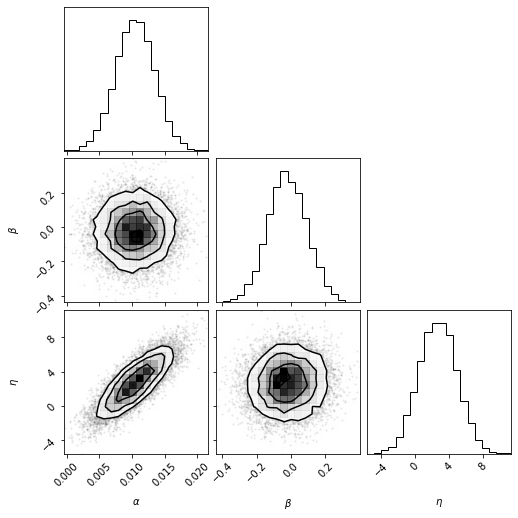

In [15]:
import corner

fig = corner.corner(flat_samples, labels=['$\\alpha$', '$\\beta$', '$\\eta$'])